In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# Load the dataset
from google.colab import files
uploaded = files.upload()

Saving climate_nasa.csv to climate_nasa.csv


In [3]:
# Read Data

df = pd.read_csv('climate_nasa.csv')
df.head()

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."


In [4]:
# Preprocess the data
df.isnull().sum()

,0
date,0
likesCount,0
profileName,0
commentsCount,278
text,18


In [6]:
df.columns

Index(['date', 'likesCount', 'profileName', 'commentsCount', 'text'], dtype='object')

In [7]:
# Fill missing values in 'commentscount' and 'text'
df['commentsCount'].fillna(df['commentsCount'].mean(), inplace=True)
df['text'].fillna("No Text", inplace=True)

df.isnull().sum()

,0
date,0
likesCount,0
profileName,0
commentsCount,0
text,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  522 non-null    float64
 4   text           522 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB


In [9]:
df.describe()

,likesCount,commentsCount
count,522.000000,522.000000
mean,4.720307,8.696721
std,12.053556,8.377096
min,0.000000,1.000000
25%,0.000000,5.000000
50%,1.000000,8.696721
75%,4.000000,8.696721
max,126.000000,93.000000


In [10]:
# Rename the column 'commentsCount' to 'comment_count'

df.rename(columns={'date':'Date_Time','likesCount': 'Likes_Count','profileName':'Profile_Name','commentsCount': 'Comment_Count','text':'Comments'}, inplace=True)

df.head()


,Date_Time,Likes_Count,Profile_Name,Comment_Count,Comments
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,8.696721,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,8.696721,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.000000,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,8.696721,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.000000,"Yes, and carbon dioxide does not harm the Eart..."


**Showing Review ratings on Review texts**

<Axes: xlabel='Likes_Count'>

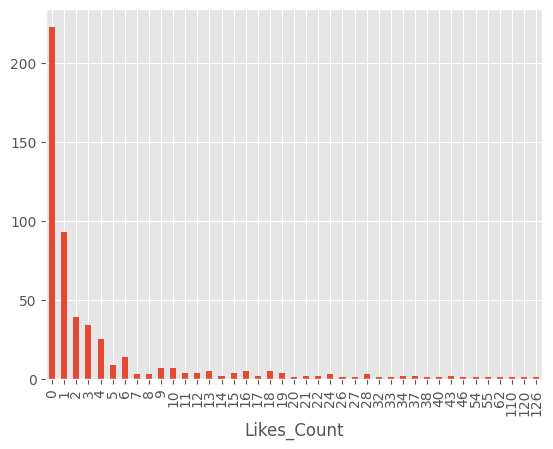

In [11]:
df.groupby('Likes_Count')['Comments'].count().plot(kind='bar')

#Exploratory data analysis (EDA)

**Sentiment Analysis of Climate Change Comments**

The Like_Count column of the data contains the likes given by every reviewer. So let’s have a look at how most of the people like the reviewers comments

In [12]:
ratings = df["Likes_Count"].value_counts()
numbers = ratings.index
quantity = ratings.values

import plotly.express as px
figure = px.pie(df,
             values=quantity,
             names=numbers,hole = 0.5)
figure.show()

So 42.7% of the comments have given zero likes and 17.8% of comments have given 1 like.

**Cleaning the test**

Now Before We Dive into extracting information out of words in text and selected text, let's first clean the data

In [13]:
import nltk
nltk.download('stopwords')

print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
port_stem = PorterStemmer()

In [16]:
def stemming(content):

  stemmed_content = re.sub('[^a-zA-Z]',' ', content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content

Make text lowercase, remove text in square brackets, remove links, remove punctuation and remove words containing numbers.

In [17]:
# Output content add into Dataset

df['stemmed_content'] = df['Comments'].apply(stemming)

In [ ]:
df.head()

,Date_Time,Likes_Count,Profile_Name,Comment_Count,Comments,stemmed_content
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,8.696721,Neat comparison I have not heard it before.\n ...,neat comparison heard would say co like disco ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,8.696721,An excellent way to visualise the invisible! T...,excel way visualis invis thank
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.000000,Does the CO2/ghg in the troposphere affect the...,co ghg tropospher affect stratospher warmer tr...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,8.696721,excellent post! I defo feel the difference - o...,excel post defo feel differ one drink make fee...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.000000,"Yes, and carbon dioxide does not harm the Eart...",ye carbon dioxid harm earth like peopl make fa...


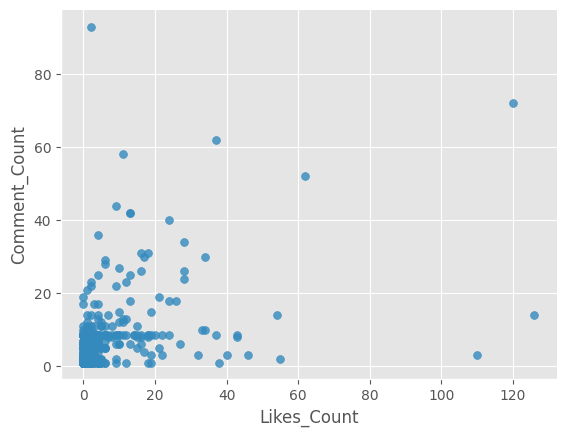

In [18]:
# Ploting Product_Id vs Product_Rating

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Likes_Count', y='Comment_Count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)


Let’s have a look at the kind of reviews people leave. For this, I will use a word cloud to visualize the most used words in the Comments column:

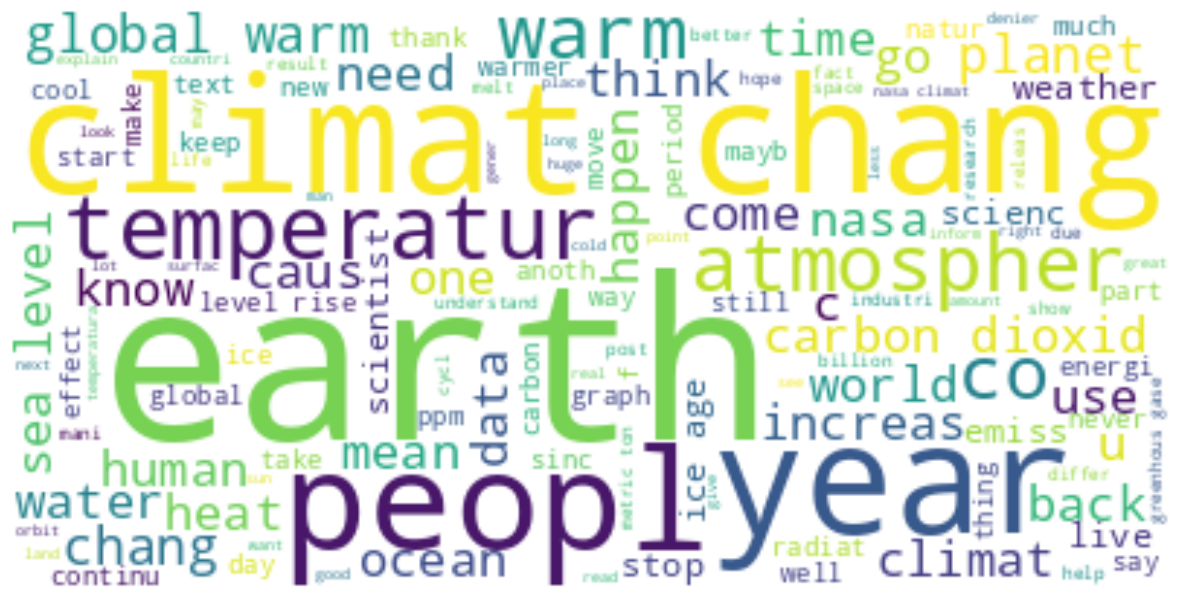

In [19]:
text = " ".join(i for i in df.stemmed_content)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Creating sentiment_label as +1 and -1 according to Review_Rating

df = df[df['Likes_Count'] != 0]

df['sentiment_label'] = df['Likes_Count'].apply(lambda rating : +1 if rating >= 4 else -1)

<ipython-input-20-f0ea189374da>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Vaders Model Downlod For Sentiment Analysis**

In [21]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [23]:
#Run the polarity score on the entire dataset on Vader

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['stemmed_content']
  myid = row['Likes_Count']
  res[myid] = sia.polarity_scores(text)

  0%|          | 0/299 [00:00<?, ?it/s]

In [24]:
# Marge with original DataFrame

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Likes_Count'})
vaders = vaders.merge(df, how='left')

In [25]:
vaders.head()

,Likes_Count,neg,neu,pos,compound,Date_Time,Profile_Name,Comment_Count,Comments,stemmed_content,sentiment_label
0,2,0.372,0.487,0.142,-0.6369,2022-09-07T17:12:32.000Z,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,8.696721,Neat comparison I have not heard it before.\n ...,neat comparison heard would say co like disco ...,-1
1,2,0.372,0.487,0.142,-0.6369,2022-11-29T21:33:48.000Z,949285743ea80b9e9b167dad354f5a5eaaf1da5b98cdc9...,8.696721,You simply can’t mess with science and the dat...,simpli mess scienc data collect thousand scien...,-1
2,2,0.372,0.487,0.142,-0.6369,2023-07-07T17:45:13.000Z,1241f3e3de1fa8971e9b840bfb90307b1fecf1083942d3...,8.696721,We all have to move to the Sahara desert and u...,move sahara desert use solar energi tree cut s...,-1
3,2,0.372,0.487,0.142,-0.6369,2023-07-10T20:00:56.000Z,f450109d7f1099c971f6bc87d710d9194992ca5d7a1691...,8.696721,Earth Sun Screen - We as Collaborative Earthli...,earth sun screen collabor earthl launch lightw...,-1
4,2,0.372,0.487,0.142,-0.6369,2023-07-08T14:48:49.000Z,04cf3010343d6f8d700ad997fcdb77736e7572329e2d4b...,8.696721,Awesome! Maybe I can start growing palm trees ...,awesom mayb start grow palm tree front yard,-1


In [26]:
vaders.tail()

,Likes_Count,neg,neu,pos,compound,Date_Time,Profile_Name,Comment_Count,Comments,stemmed_content,sentiment_label
294,126,0.000,0.756,0.244,0.4404,2022-12-22T18:12:11.000Z,e0d27ee7aba5366ee0cfa5b8b0c1f60551d805c253d46d...,14.0,I can only hope to someday attain the level of...,hope someday attain level patienc person run n...,1
295,38,0.265,0.602,0.133,-0.2960,2022-12-22T17:13:36.000Z,06c157adbace820ac323ec2c6af6ebffc51c26080bb75a...,1.0,The deniers don’t realize that it may be 20 de...,denier realiz may degre colder much warmer som...,1
296,55,0.134,0.738,0.128,-0.0258,2022-12-22T17:13:44.000Z,cb6d9abbee087b6ef28063c4b50fe2a4ae6780dedd9863...,2.0,To those who cite a very cold day as evidence ...,cite cold day evid global warm stephen colbert...,1
297,46,0.291,0.709,0.000,-0.5719,2023-12-14T16:17:28.000Z,966bf9d33345ac00ef0e80cf9ce16607e427e988629096...,3.0,Waiting for the science illiterates to come te...,wait scienc illiter come tell us scam math che...,1
298,32,0.167,0.833,0.000,-0.1027,2023-12-14T16:14:23.000Z,81e1b1a664381f4b02a092c3d09c1dd1529772eab76e79...,3.0,Gosh if only people had been warning about lit...,gosh peopl warn liter exact scenario dunno year,1


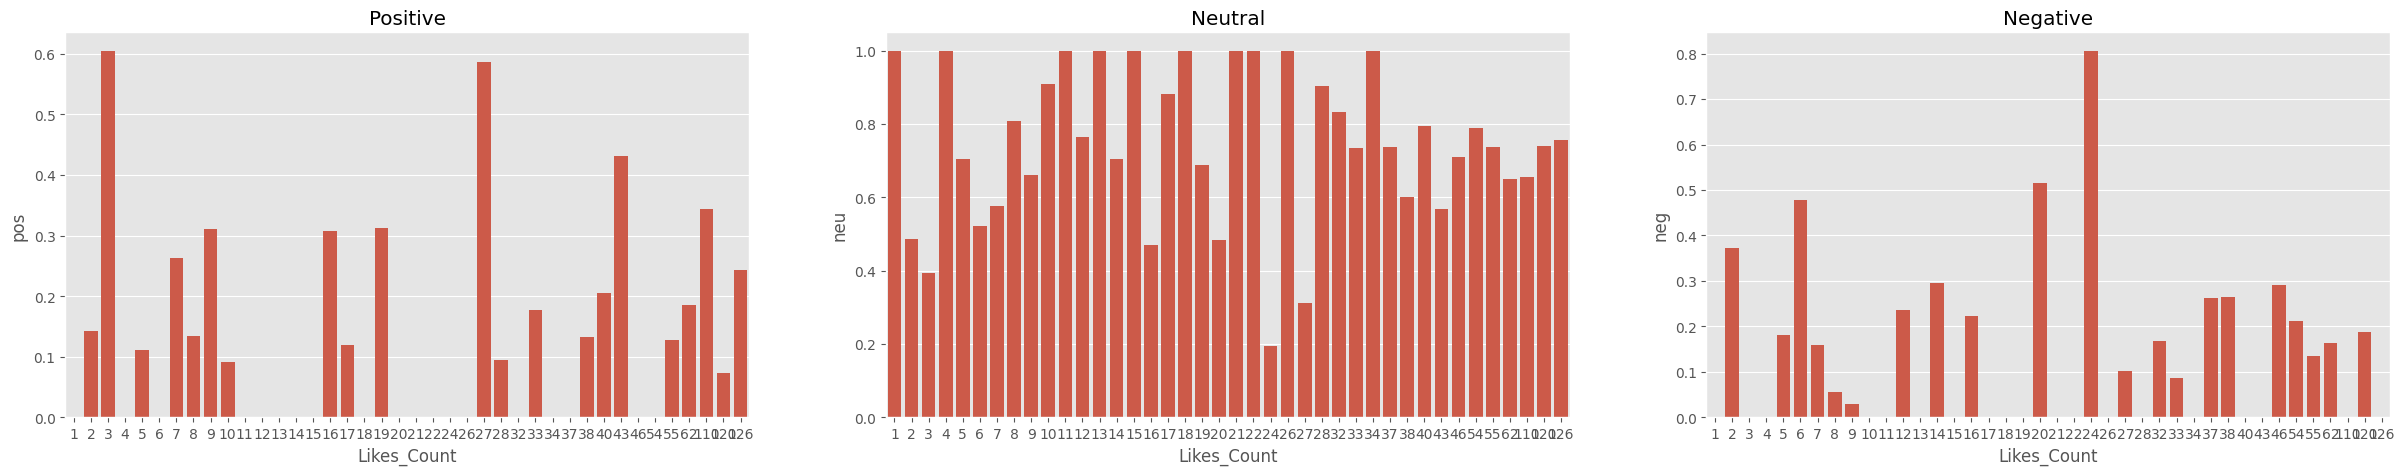

In [27]:
# Showing the positive, negative and neutral sentiments of Reviewers


fig, axs = plt.subplots(1, 3, figsize= (30,5))
sns.barplot(data= vaders, x= 'Likes_Count', y= 'pos', ax=axs[0])
sns.barplot(data= vaders, x= 'Likes_Count', y= 'neu', ax=axs[1])
sns.barplot(data= vaders, x= 'Likes_Count', y= 'neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()


**Roberta Pretrained Model**

In [28]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [29]:
Model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(Model)
model = AutoModelForSequenceClassification.from_pretrained(Model)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [30]:
# Run for Roberta Model

def polarity_scores_roberta(df):
  encoded_test = tokenizer(df, return_tensors='pt')
  output = model(**encoded_test)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      'roberta_neg' : scores[0],
      'roberta_neu' : scores[1],
      'roberta_pos' : scores[2]}
  return scores_dict


In [31]:
roberta_result = polarity_scores_roberta('stemmed_content')
roberta_result


{'roberta_neg': 0.12495981, 'roberta_neu': 0.766026, 'roberta_pos': 0.10901412}

Here I obtain Roberta Negative, Neutral, and Positive Score, which clearly shows that neutral sentiment is more than the positive and negative sentiment from the Comments.

In [32]:
# Run the polarity score on the entire dataset

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
     text = row['stemmed_content']
     myid = row['Likes_Count']
     vader_result = sia.polarity_scores(text)
     roberta_result = polarity_scores_roberta(text)
     both = {**vader_result, **roberta_result}
     res[myid] = both
  except RuntimeError:
    print(f'Broke for id {myid}')

  0%|          | 0/299 [00:00<?, ?it/s]

In [33]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Likes_Count'})
results_df = results_df.merge(df, how='left')

In [34]:
results_df.head()

,Likes_Count,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,Date_Time,Profile_Name,Comment_Count,Comments,stemmed_content,sentiment_label
0,2,0.372,0.487,0.142,-0.6369,0.722035,0.267554,0.010411,2022-09-07T17:12:32.000Z,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,8.696721,Neat comparison I have not heard it before.\n ...,neat comparison heard would say co like disco ...,-1
1,2,0.372,0.487,0.142,-0.6369,0.722035,0.267554,0.010411,2022-11-29T21:33:48.000Z,949285743ea80b9e9b167dad354f5a5eaaf1da5b98cdc9...,8.696721,You simply can’t mess with science and the dat...,simpli mess scienc data collect thousand scien...,-1
2,2,0.372,0.487,0.142,-0.6369,0.722035,0.267554,0.010411,2023-07-07T17:45:13.000Z,1241f3e3de1fa8971e9b840bfb90307b1fecf1083942d3...,8.696721,We all have to move to the Sahara desert and u...,move sahara desert use solar energi tree cut s...,-1
3,2,0.372,0.487,0.142,-0.6369,0.722035,0.267554,0.010411,2023-07-10T20:00:56.000Z,f450109d7f1099c971f6bc87d710d9194992ca5d7a1691...,8.696721,Earth Sun Screen - We as Collaborative Earthli...,earth sun screen collabor earthl launch lightw...,-1
4,2,0.372,0.487,0.142,-0.6369,0.722035,0.267554,0.010411,2023-07-08T14:48:49.000Z,04cf3010343d6f8d700ad997fcdb77736e7572329e2d4b...,8.696721,Awesome! Maybe I can start growing palm trees ...,awesom mayb start grow palm tree front yard,-1


**Compare Scores between models**

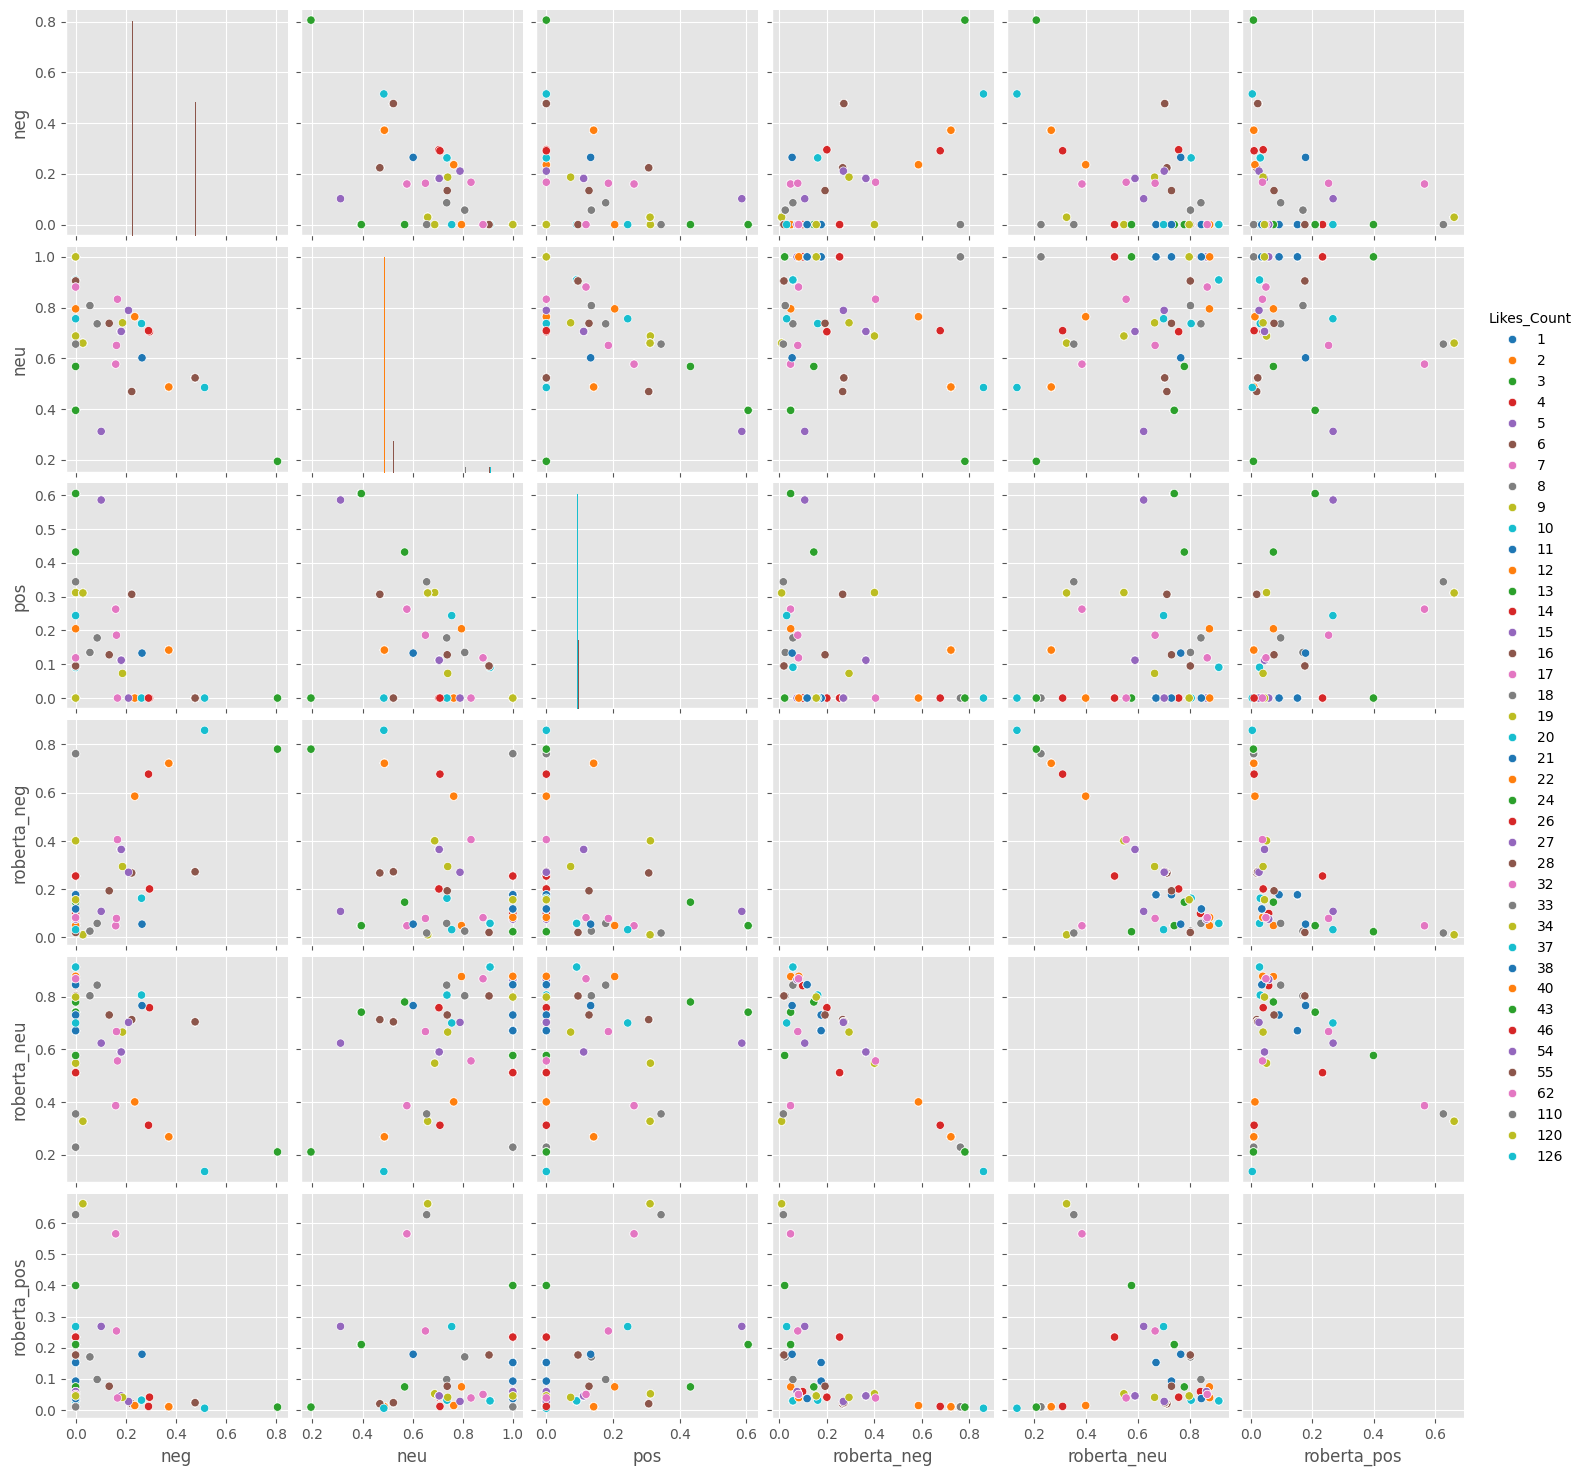

In [35]:
sns.pairplot(data=results_df,
             vars=['neg', 'neu', 'pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue= 'Likes_Count', palette = 'tab10')
plt.show()

In [36]:
# Creates TF-IDF vectorizer and transforms the corpus

vectorizer = TfidfVectorizer()
reviews_corpus = vectorizer.fit_transform(df.stemmed_content)
reviews_corpus.shape

(299, 1727)

In [37]:
#Apply label encoding to the Review_Rating column

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['review_encoded'] = encoder.fit_transform(df['sentiment_label'])


In [38]:
# Dependent feature

review = df['review_encoded']
review.shape

(299,)

**Split the data in train and test**

In [39]:
X_train,X_test,Y_train,Y_test = train_test_split(reviews_corpus,review,test_size=0.20,random_state=42)
print('Train data shape ',X_train.shape,Y_train.shape)
print('Test data shape ',X_test.shape,Y_test.shape)

Train data shape  (239, 1727) (239,)
Test data shape  (60, 1727) (60,)


**Apply Multinomial Naive Bayes**

Multinomial Naive Bayes is useful for determining the emotional tone of a piece of text, such as a tweet, product review, or customer feedbacks. The model works by computing the probability of each possible sentiment label (positive, negative, neutral) given a piece of text.

Accuracy: 0.45
Confusion Matrix
[[22 23]
 [10  5]]
Accuracy:  0.45


[[22 10]
 [23  5]]
              precision    recall  f1-score   support

           0       0.49      0.69      0.57        32
           1       0.33      0.18      0.23        28

    accuracy                           0.45        60
   macro avg       0.41      0.43      0.40        60
weighted avg       0.42      0.45      0.41        60



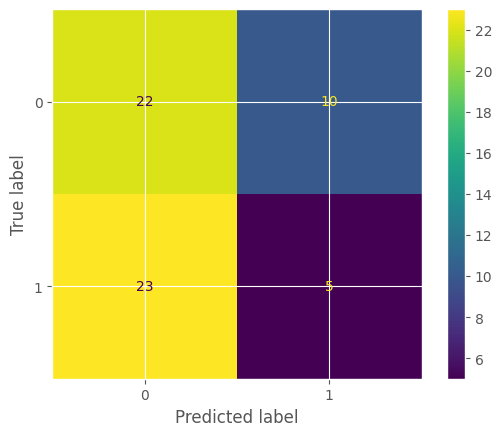

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # Import necessary modules

clf = MultinomialNB().fit(X_train, Y_train) #fit the training data

Y_pred = clf.predict(X_test) #predict the sentiment for test data and store the result

print("Accuracy: %s" % str(clf.score(X_test, Y_test))) #check accuracy
print("Confusion Matrix")
print(confusion_matrix(Y_pred, Y_test)) #print confusion matrix

accuracy_NB = accuracy_score(Y_test,Y_pred)
print("Accuracy: ",accuracy_NB)
print('\n')
print(ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)) # Now ConfusionMatrixDisplay should work
print(confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred))


Accurscy result 45%

**Fit the model and predict the output by using RandomForestClassifier**

Accuracy: 0.5666666666666667
Confusion Matrix
[[29 23]
 [ 3  5]]
Accuracy:  0.5666666666666667


[[28  4]
 [22  6]]
              precision    recall  f1-score   support

           0       0.56      0.88      0.68        32
           1       0.60      0.21      0.32        28

    accuracy                           0.57        60
   macro avg       0.58      0.54      0.50        60
weighted avg       0.58      0.57      0.51        60



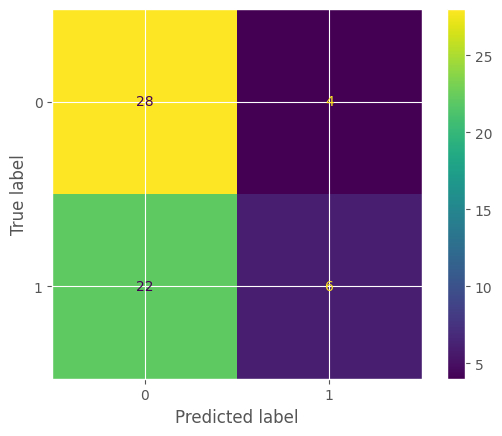

In [46]:
clf = RandomForestClassifier().fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

print("Accuracy: %s" % str(clf.score(X_test, Y_test)))
print("Confusion Matrix")
print(confusion_matrix(pred, Y_test))

accuracy_RF = accuracy_score(Y_test,Y_pred)
print("Accuracy: ",accuracy_RF)
print('\n')
print(ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)) # Now ConfusionMatrixDisplay should work
print(confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred))

Accuracy result 56%

**Conclusion**

* After transforming my reviews into vectors using TfidfVectorizer and running both NaiveBayes and RandomForestClassifier, I discovered that RandomForestClassifier outperformed MultinomialNB. I achieved 56%  accuracy with RandomForestClassifier without any parameter adjustment. However, I can still enhance my accuracy by adjusting the parameters of my classifier.


* RandomForestClassifier proved better for sentiment analysis as the model contains labeled dataset of texts with corresponding sentiment labels (positive, negative, neutral).